# 小组成员
 1. 信息2301, 2310650118, 洪菁曼 （组长）
 2. 信息2302, 2310650219, 安雨琪

# 工作日志
## 问题一（安雨琪）
1. 2026-01-03 数据预处理 主要是将附件2各行重命名转换日期，附件一附件二通过单品编码的主键合并数据（数据库）
     * 预处理时发现反复运行合并数据会报错，删除已有重复列解决这个问题
2. 2026-01-03 基础分析 （1）将单品销售量前十列出 （2）6个品类年度分析、季度分析 （3）周末对比平常
     * 基础分析的一些方法不确定要不要做两个人讨论了一下决定从年、季度、周末入手
3. 2026-01-03 聚类分析 进行品类的聚类分组：分了三个类 、随机森林（回归分析）来说明各品类之间的相关关系；用spearman来进行销量和价格的相关性分析
     * 相关分析，一开始只采用了聚类分析和随机森林，发现描述的不够准确不太适合这类问题，进而选择用spearman和person。因为规律大概率不是线性的 所以用的spearman。spearman中一开始写的冗余代码太多一直在重复。后改进了写法，用封装的函数来优化代码

 智能商务数据分析实践  课程考核题目及要求

任务要求：
选题二选一完成，分组2~3人一组。
独立实践报告采用Jupyter写，最后在线提交notebook原文件以及其导出的PDF文件，无需包含原始数据，打包成ZIP包。
Jupyter笔记的的第一个Markdown单元格内必须写成员的班级、学号、姓名

报告的第二个Markdown单元格，写工作日志，至少4条以上，内容写标志性、自己做过努力的、跳过的坑。

1. 202x-xx-xx 对数据进行了...统计分析
1. 202x-xx-xx 补充了...分析
1. 202x-xx-xx 采用...交叉验证对选择模型..
1. ...
报告必须有相应的分析或说明文字，需要必要的完整中间过程（程序和输出结果）
报告最多分两级标题（章和节）
成员多于1人的小组，在报告每个第二级（节）的末尾以陈述方式说明成员的工作。

> 张三承担...完成...


选题2：蔬菜类商品的自动定价与补货决策问题

问题：
在生鲜商超中，一般蔬菜类商品的保鲜期都比较短，且品相随销售时间的增加而变差，大部分品种如当日未售出，隔日就无法再售。因此，商超通常会根据各商品的历史销售和需求情况每天进行补货。

由于商超销售的蔬菜品种众多、产地不尽相同，而蔬菜的进货交易时间通常在凌晨 3:00-4:00，为此商家须在不确切知道具体单品和进货价格的情况下，做出当日各蔬菜品类的补货决策。蔬菜的定价一般采用“成本加成定价”方法，商超对运损和品相变差的商品通常进行打折销售。可靠的市场需求分析，对补货决策和定价决策尤为重要。从需求侧来看，蔬菜类商品的销售量与时间往往存在一定的关联关系；从供给侧来看，蔬菜的供应品种在4月至10月较为丰富，商超销售空间的限制使得合理的销售组合变得极为重要。

附件1给出了某商超经销的6个蔬菜品类的商品信息；附件2和附件3分别给出了该商超2020年7月1日至2023年6月30日各商品的销售流水明细与批发价格的相关数据；附件4给出了各商品近期的损耗率数据。

请根据附件和实际情况建立数学模型解决以下问题：
问题1 蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。
问题2 考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略，使得商超收益最大。
问题3 因蔬菜类商品的销售空间有限，商超希望进一步制定单品的补货计划，要求可售单品总数控制在 27-33 个，且各单品订购量满足最小陈列量 2.5 千克的要求。根据 2023 年 6 月 24-30 日的可售品种，给出 7 月 1 日的单品补货量和定价策略，在尽量满足市场对各品类蔬菜商品需求的前提助，请给出你们的意见和理由。

数据文件：
附件1 数据文件是6个蔬菜品类的商品信息
附件2 销售流水明细数据
附件3 蔬菜类商品的批发价格
附件4 蔬菜类商品的近期损耗率
附件说明：
附件1中部分单品名称包含的数字编号表示不同的供应来源。
附件4中的损耗率反映了近期商品的损耗情况，通过近期盘点周期的数据计算得到。


# 数据预处理

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import os
import seaborn as sns
warnings.filterwarnings('ignore')

# 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [73]:
def smart_loader(file_path, sheet_name='Sheet1'):
    """附件parquet缓存加载器，提升数据读取效率"""

    cache_file = os.path.splitext(file_path)[0] + '.parquet'
    
    # 1. 命中缓存：直接读取
    if os.path.exists(cache_file):
        print(f"读取缓存: {cache_file}")
        return pd.read_parquet(cache_file)
    
    # 2. 未命中缓存：读取原始文件
    print(f"读取原始文件: {file_path}")
    if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        df = pd.read_excel(file_path, sheet_name=sheet_name)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)

    # 字符串 -> 分类    
    for col in df.select_dtypes(include=['object']).columns:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    # 日期列转换
    if '销售日期' in df.columns:
        df['销售日期'] = pd.to_datetime(df['销售日期'])

    # 3. 保存为 Parquet
    df.to_parquet(cache_file, engine='pyarrow')
    print(f"已创建缓存文件: {cache_file}")
    
    return df

In [ ]:
try:
    raw_sales = smart_loader('./选题2-蔬菜自动定价与补货决策/附件2.xlsx')
    raw_category = smart_loader('./选题2-蔬菜自动定价与补货决策/附件1.xlsx')
    raw_wholesale = smart_loader('./选题2-蔬菜自动定价与补货决策/附件3.xlsx')
    raw_loss = smart_loader('./选题2-蔬菜自动定价与补货决策/附件4.xlsx')
except Exception as e:
    print(f" 读取失败: {e}")
    exit()

读取缓存: ./选题2-蔬菜自动定价与补货决策/附件2.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件1.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件3.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件4.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件4.parquet


# 问题1
蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。

品类：分类名称

In [48]:
def filter_active_skus(df, min_days_span=730):
    """
    销售持续性筛选：
    1. 2023年仍在售
    2. 销售跨度长: 第一次卖和最后一次卖中间至少间隔 min_days_span 天。
    """
    print(f"\n 持续性较好单品筛选 (策略: 2023在售 + 跨度>{min_days_span}天)...")
    
    # 计算每个单品的生命周期统计量min: 首次销售, max: 最后销售, count: 销售频次
    sku_stats = df.groupby('单品编码')['日期'].agg(['min', 'max', 'count'])
    sku_stats.columns = ['first_date', 'last_date', 'sales_frequency']
    sku_stats['duration_days'] = (sku_stats['last_date'] - sku_stats['first_date']).dt.days
    
    # 条件A: 2023年仍在售 (最后一次销售日期 >= 2023-01-01)
    condition_active_2023 = sku_stats['last_date'].dt.year == 2023
    
    # 条件B: 销售跨度足够长
    condition_long_duration = sku_stats['duration_days'] >= min_days_span

    valid_skus = sku_stats[condition_active_2023 & condition_long_duration].index
    
    total = len(sku_stats)
    kept = len(valid_skus)
    print(f"   - 原始单品数: {total}")
    print(f"   - 筛选后单品数: {kept}")
    print(f"   - 淘汰率: {(1 - kept/total):.1%}")
    print(f"     (其中: {sum(~condition_active_2023)} 个单品在2023年前已退市)")
    
    return df[df['单品编码'].isin(valid_skus)]

def get_season(month):
    if month in [3, 4, 5]: return '春季'
    elif month in [6, 7, 8]: return '夏季'
    elif month in [9, 10, 11]: return '秋季'
    else: return '冬季'

def process_sales_pipeline(raw_sales, raw_category, min_price_threshold=0.1):
    """
    数据清洗和整合日数据
    """
    # ---------------------------------------------------------
    df = raw_sales.copy()
    # 规范化列名
    df.columns = ['销售日期', '扫码时间', '单品编码', '销量', '单价', '销售类型', '是否打折']
    df['日期'] = pd.to_datetime(df['销售日期'])
    
    # 过滤：剔除退货和异常数据（销量<=0 或 单价<0.05）
    mask_valid = (df['销售类型'] == '销售') & (df['销量'] > 0) & (df['单价'] >= min_price_threshold)
    df = df[mask_valid]
    
    # 合并商品信息
    category_info = raw_category[['单品编码', '分类名称', '单品名称']].drop_duplicates()
    df = pd.merge(df, category_info, on='单品编码', how='left')
    df['分类名称'] = df['分类名称'].astype(str).replace('nan', '未知品类')

    df = filter_active_skus(df)
    
    print(f" 1.基础清洗完成: {len(df)} 条有效记录")

    # ---------------------------------------------------------
    print("\n 2.正在检查价格一致性...")
    # 统计每天每个单品有多少个不同的单价
    price_counts = df.groupby(['日期', '单品编码'])['单价'].nunique()
    inconsistent_mask = price_counts > 1
    
    if inconsistent_mask.any():
        num_issues = inconsistent_mask.sum()
        total_groups = len(price_counts)
        print(f"    发现价格差异: 在 {total_groups} 个(天/单品)组合中，有 {num_issues} 个存在一日多价情况。")
        print(f"      比例: {num_issues/total_groups:.2%}")
        print("      >> 处理策略: 将自动计算 '加权平均单价' (总金额/总销量) 以消除差异。")
    else:
        print("    所有单品每日价格唯一。")

    # ---------------------------------------------------------
    print("\n 3.正在执行日数据...")
    df['销售额'] = df['销量'] * df['单价']
    # --- A. 生成单品日数据 (用于 Q1单品分析 和 Q3) ---
    df_sku_daily = df.groupby(['日期', '分类名称', '单品编码', '单品名称']).agg({
        '销量': 'sum',
        '销售额': 'sum'
    }).reset_index()
    # 计算加权均价
    df_sku_daily['加权单价'] = df_sku_daily['销售额'] / df_sku_daily['销量']
    # --- B. 生成品类日数据 (用于 Q1品类分析 和 Q2) ---
    df_cat_daily = df.groupby(['日期', '分类名称']).agg({
        '销量': 'sum',
        '销售额': 'sum'
    }).reset_index()
    df_cat_daily['加权单价'] = df_cat_daily['销售额'] / df_cat_daily['销量']
    
    # ---------------------------------------------------------
    for data in [df_sku_daily, df_cat_daily]:
        data['年份'] = data['日期'].dt.year
        data['月份'] = data['日期'].dt.month
        data['季度'] = data['日期'].dt.quarter
        data['星期'] = data['日期'].dt.weekday # 0-6
        data['是否周末'] = data['星期'].isin([5, 6])
        
        data['季节'] = data['月份'].apply(get_season)
        data['季节'] = pd.Categorical(data['季节'], categories=['春季', '夏季', '秋季', '冬季'], ordered=True)
    
    print(f" 处理完毕!")
    print(f"   单品日数据: {df_sku_daily.shape}")
    print(f"   品类日数据: {df_cat_daily.shape}")
    
    return df_sku_daily, df_cat_daily

In [49]:
df_sku_daily, df_cat_daily = process_sales_pipeline(raw_sales, raw_category)


 持续性较好单品筛选 (策略: 2023在售 + 跨度>730天)...
   - 原始单品数: 246
   - 筛选后单品数: 68
   - 淘汰率: 72.4%
     (其中: 110 个单品在2023年前已退市)
 1.基础清洗完成: 641325 条有效记录

 2.正在检查价格一致性...
    发现价格差异: 在 29697 个(天/单品)组合中，有 1791 个存在一日多价情况。
      比例: 6.03%
      >> 处理策略: 将自动计算 '加权平均单价' (总金额/总销量) 以消除差异。

 3.正在执行日数据...
 处理完毕!
   单品日数据: (29697, 13)
   品类日数据: (6447, 11)


In [50]:
df_sku_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29697 entries, 0 to 29696
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      29697 non-null  datetime64[ns]
 1   分类名称    29697 non-null  object        
 2   单品编码    29697 non-null  int64         
 3   单品名称    29697 non-null  object        
 4   销量      29697 non-null  float64       
 5   销售额     29697 non-null  float64       
 6   加权单价    29697 non-null  float64       
 7   年份      29697 non-null  int32         
 8   月份      29697 non-null  int32         
 9   季度      29697 non-null  int32         
 10  星期      29697 non-null  int32         
 11  是否周末    29697 non-null  bool          
 12  季节      29697 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int32(4), int64(1), object(2)
memory usage: 2.1+ MB


In [51]:
df_sku_daily.head()

,日期,分类名称,单品编码,单品名称,销量,销售额,加权单价,年份,月份,季度,星期,是否周末,季节
0,2020-07-01,水生根茎类,102900005118824,高瓜(1),4.119,41.1900,10.0,2020,7,3,2,False,夏季
1,2020-07-01,水生根茎类,102900051000944,洪湖藕带,0.731,29.0938,39.8,2020,7,3,2,False,夏季
2,2020-07-01,花叶类,102900005115762,苋菜,6.841,41.0460,6.0,2020,7,3,2,False,夏季
3,2020-07-01,花叶类,102900005115779,云南生菜,41.966,335.7280,8.0,2020,7,3,2,False,夏季
4,2020-07-01,花叶类,102900005115786,竹叶菜,11.352,68.1120,6.0,2020,7,3,2,False,夏季


In [52]:
df_cat_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6447 entries, 0 to 6446
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      6447 non-null   datetime64[ns]
 1   分类名称    6447 non-null   object        
 2   销量      6447 non-null   float64       
 3   销售额     6447 non-null   float64       
 4   加权单价    6447 non-null   float64       
 5   年份      6447 non-null   int32         
 6   月份      6447 non-null   int32         
 7   季度      6447 non-null   int32         
 8   星期      6447 non-null   int32         
 9   是否周末    6447 non-null   bool          
 10  季节      6447 non-null   category      
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int32(4), object(1)
memory usage: 365.5+ KB


## 统计 + 相关分析

📊 === 分类名称 全方位分布规律分析 ===



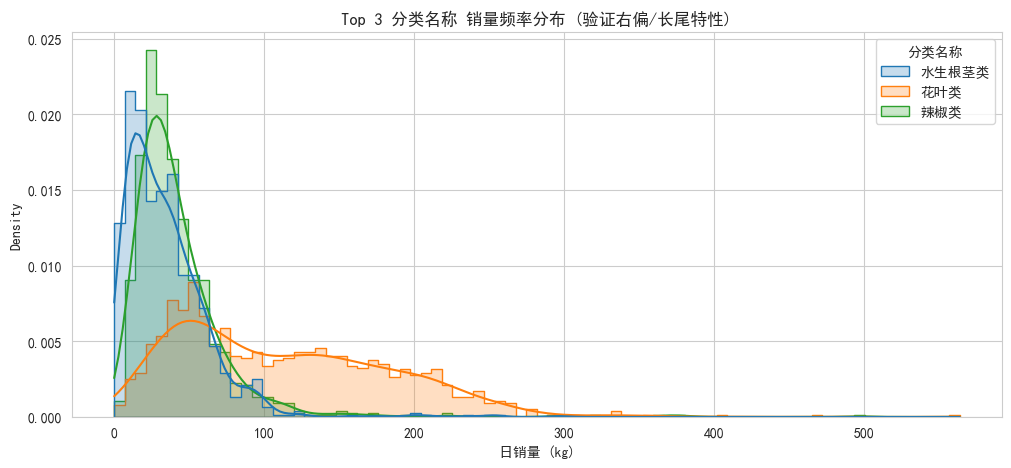

   💡 解读: 如果曲线呈现'左高右低'拖着长尾巴，说明是典型的右偏分布。这意味着大部分时间销量稳定，但需警惕偶尔的爆发性需求。


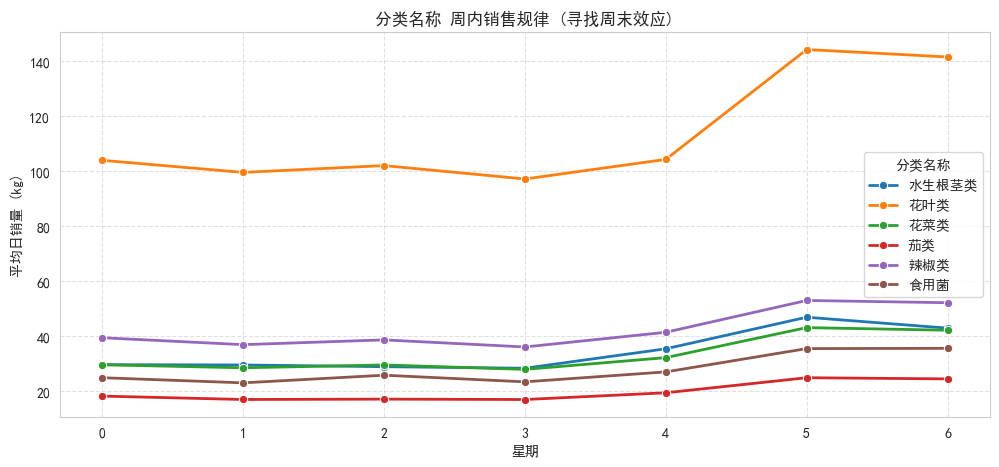

📊 === 单品名称 全方位分布规律分析 ===



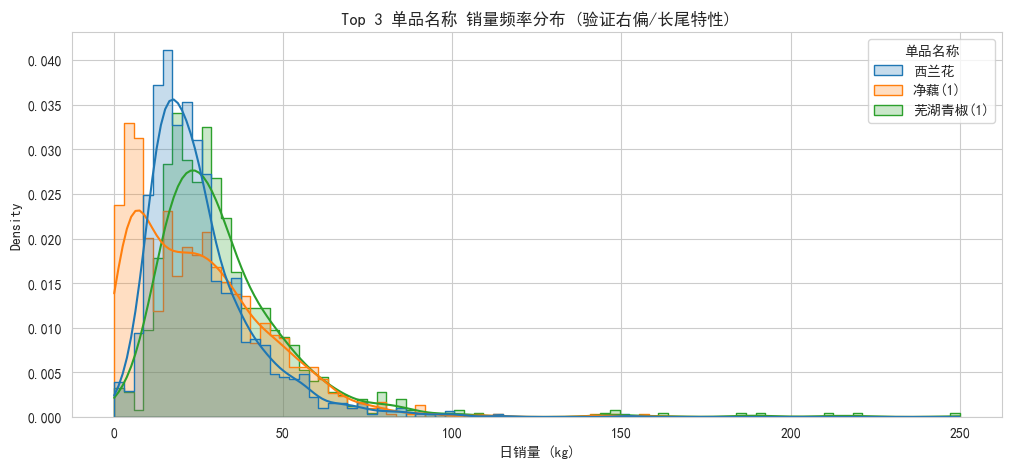

   💡 解读: 如果曲线呈现'左高右低'拖着长尾巴，说明是典型的右偏分布。这意味着大部分时间销量稳定，但需警惕偶尔的爆发性需求。


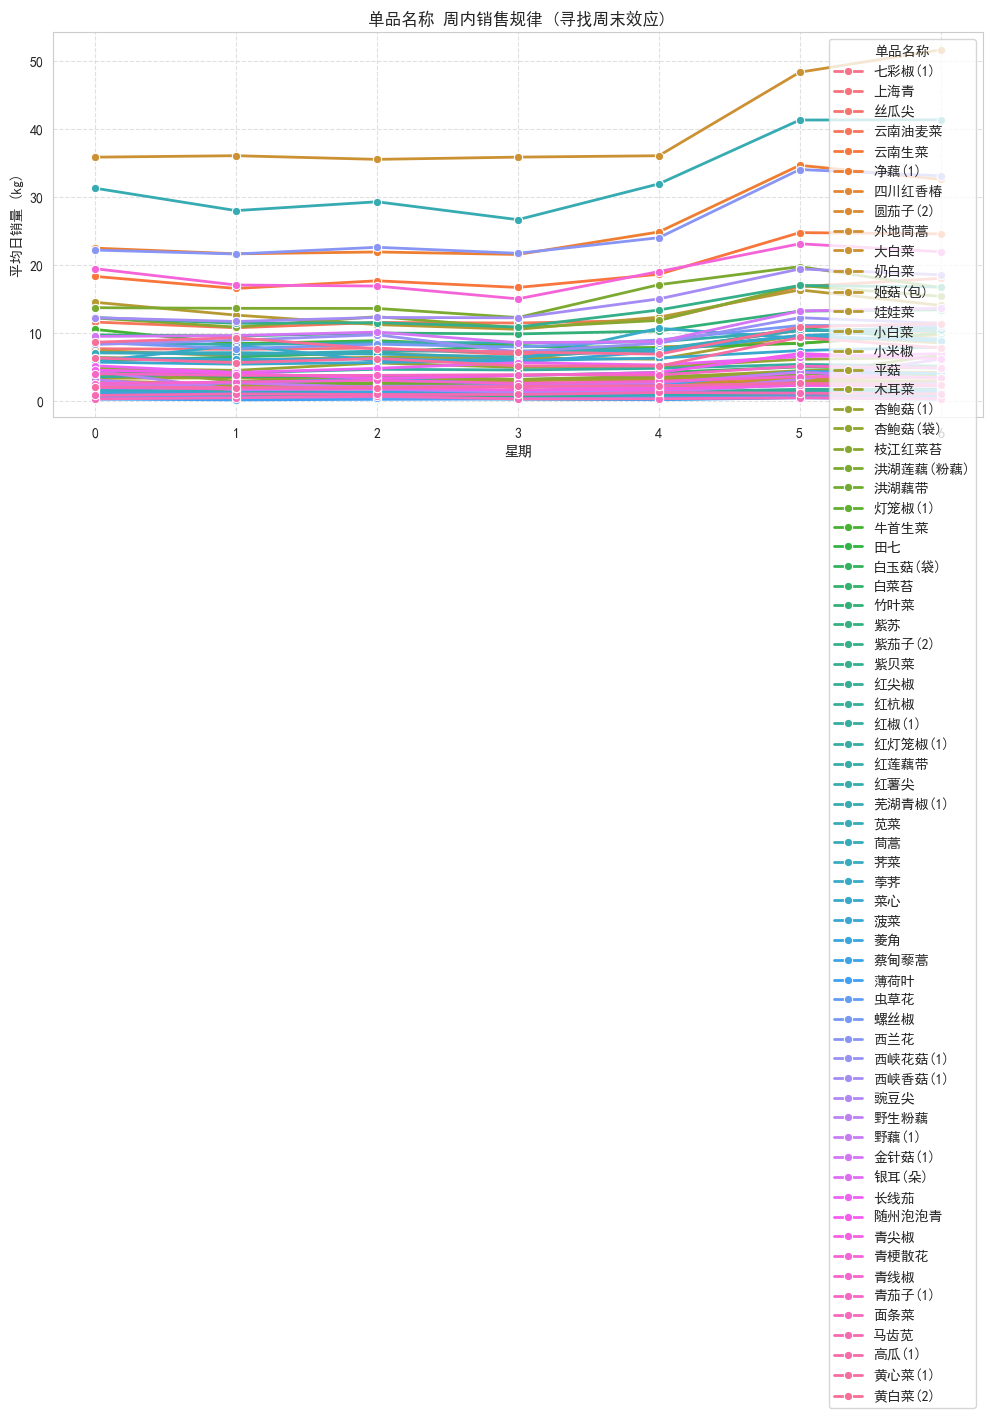


🏆 [核心单品识别 - ABC分析]
        单品名称  单品数量占比  销量贡献占比
类别                          
A类(核心)    20  0.2941  0.7984
B类(次要)    15  0.2206  0.1485
C类(长尾)    33  0.4853  0.0531


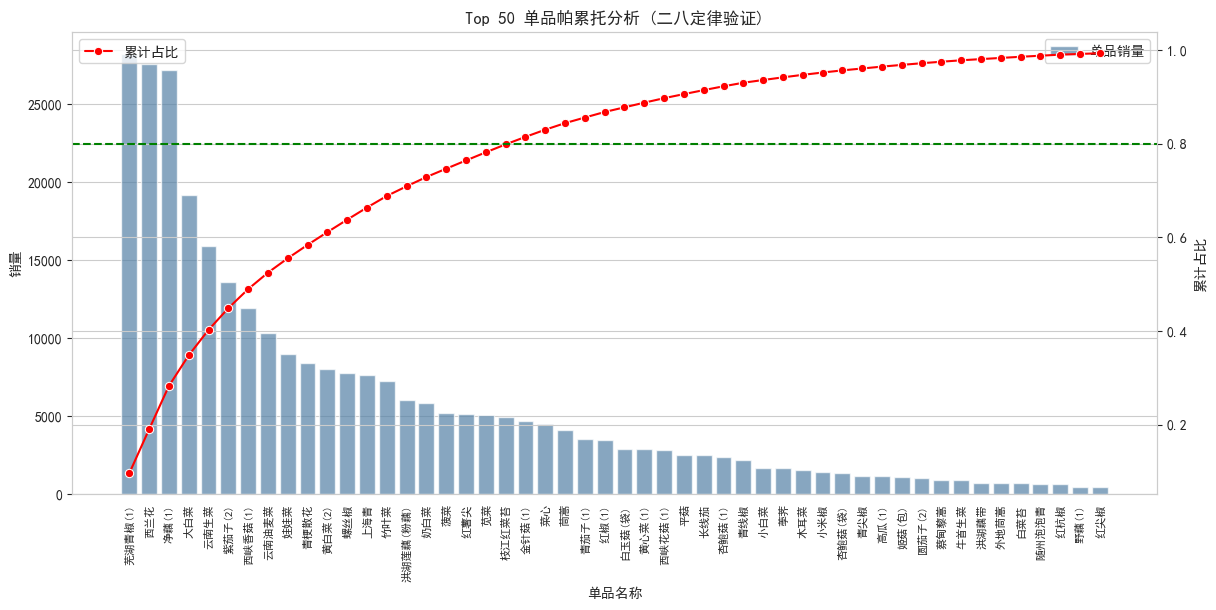

In [53]:
def analyze_comprehensive_distribution(df_daily, level_name='分类名称'):
    """
    全方位分布规律分析：统计形态 + 周期规律 + ABC分析
    """
    print(f"📊 === {level_name} 全方位分布规律分析 ===\n")
    
    # 设置绘图风格
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示
    plt.rcParams['axes.unicode_minus'] = False
    
    # ------------------------------------------------------
    # 1. 统计形态分析 (直方图 + KDE)
    # ------------------------------------------------------
    plt.figure(figsize=(12, 5))
    
    # 选择销量最大的前3个品类/单品进行展示，避免图太乱
    top_items = df_daily.groupby(level_name)['销量'].sum().nlargest(3).index
    subset = df_daily[df_daily[level_name].isin(top_items)]
    
    sns.histplot(data=subset, x='销量', hue=level_name, kde=True, element="step", stat="density", common_norm=False)
    plt.title(f'Top 3 {level_name} 销量频率分布 (验证右偏/长尾特性)')
    plt.xlabel('日销量 (kg)')
    plt.show()
    print("   💡 解读: 如果曲线呈现'左高右低'拖着长尾巴，说明是典型的右偏分布。这意味着大部分时间销量稳定，但需警惕偶尔的爆发性需求。")

    # ------------------------------------------------------
    # 2. 周度模式分析 (Weekly Pattern)
    # ------------------------------------------------------
    # 聚合计算：星期 x 品类 的平均销量
    weekly_pattern = df_daily.groupby(['星期', level_name])['销量'].mean().reset_index()
    # 将数字星期转换为中文
    week_map = {0:'周一', 1:'周二', 2:'周三', 3:'周四', 4:'周五', 5:'周六', 6:'周日'}
    weekly_pattern['星期中文'] = weekly_pattern['星期'].map(week_map)
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=weekly_pattern, x='星期', y='销量', hue=level_name, marker='o', linewidth=2)
    plt.title(f'{level_name} 周内销售规律 (寻找周末效应)')
    plt.ylabel('平均日销量 (kg)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # ------------------------------------------------------
    # 3. ABC 分析 (帕累托图) - 仅针对“单品”层面才有意义
    # ------------------------------------------------------
    if level_name == '单品名称':
        print(f"\n🏆 [核心单品识别 - ABC分析]")
        # 按总销量排序
        sku_sales = df_daily.groupby(level_name)['销量'].sum().sort_values(ascending=False).reset_index()
        sku_sales['累计销量'] = sku_sales['销量'].cumsum()
        sku_sales['累计占比'] = sku_sales['累计销量'] / sku_sales['销量'].sum()
        
        # 划分 ABC 类
        # A类: 累计占比 < 80% (核心)
        # B类: 80% - 95% (次要)
        # C类: > 95% (长尾)
        def get_abc_class(cumsum_ratio):
            if cumsum_ratio <= 0.80: return 'A类(核心)'
            elif cumsum_ratio <= 0.95: return 'B类(次要)'
            else: return 'C类(长尾)'
            
        sku_sales['类别'] = sku_sales['累计占比'].apply(get_abc_class)
        
        # 统计各类别的数量
        abc_summary = sku_sales.groupby('类别').agg({'单品名称':'count', '销量':'sum'}).sort_values('销量', ascending=False)
        abc_summary['单品数量占比'] = abc_summary['单品名称'] / len(sku_sales)
        abc_summary['销量贡献占比'] = abc_summary['销量'] / sku_sales['销量'].sum()
        
        print(abc_summary[['单品名称', '单品数量占比', '销量贡献占比']].round(4))
        
        # 绘制帕累托图 (前50个单品)
        plt.figure(figsize=(14, 6))
        top_50 = sku_sales.head(50)
        ax1 = sns.barplot(x='单品名称', y='销量', data=top_50, color='steelblue', alpha=0.7, label='单品销量')
        ax2 = ax1.twinx()
        sns.lineplot(x='单品名称', y='累计占比', data=top_50, color='red', marker='o', ax=ax2, label='累计占比')
        
        ax2.axhline(0.8, color='green', linestyle='--', label='80% 分界线')
        
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=8)
        plt.title('Top 50 单品帕累托分析 (二八定律验证)')
        plt.show()

# === 执行分析 ===
# 1. 对品类进行分布和周期分析
analyze_comprehensive_distribution(df_cat_daily, level_name='分类名称')

# 2. 对单品进行ABC分析 (假设你之前生成的单品日数据叫 df_sku_daily)
# 注意：这里会输出非常关键的结论，比如“前 15% 的单品贡献了 80% 的利润”
analyze_comprehensive_distribution(df_sku_daily, level_name='单品名称')

In [54]:
def analyze_distribution(df_daily, level_name='分类名称'):
    """销量的分布规律 (基于日数据)"""
    # 1. 箱线图
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=level_name, y='销量', data=df_daily)
    plt.yscale('log') # 销量差异大，建议用对数坐标
    plt.title(f'各{level_name}日销量分布 (Log Scale)')
    plt.xticks(rotation=45)
    plt.show()
    
    # 2. 月度趋势 (聚合到月看大趋势)
    df_monthly = df_daily.groupby([pd.Grouper(key='日期', freq='M'), level_name])['销量'].sum().reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='日期', y='销量', hue=level_name, data=df_monthly, marker='o')
    plt.title(f'各{level_name}月度销量趋势（前10）')
    plt.show()

def analyze_correlation(df_daily, level_name='分类名称'):
    """
    Spearman相关性矩阵并画热力图
    """
    # 数据透视 (Pivot): 必须转成 行=日期, 列=品类, 值=销量 的宽表
    # fillna(0) 是核心：某天某品类没卖出，销量是0，不是缺失值
    pivot_df = df_daily.pivot_table(index='日期', columns=level_name, values='销量', aggfunc='sum').fillna(0)
    
    corr_matrix = pivot_df.corr(method='spearman')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'{level_name} 销量相关性分析 (Spearman)')
    plt.show()
    
    return corr_matrix

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


--- 1. 品类层面分析 ---


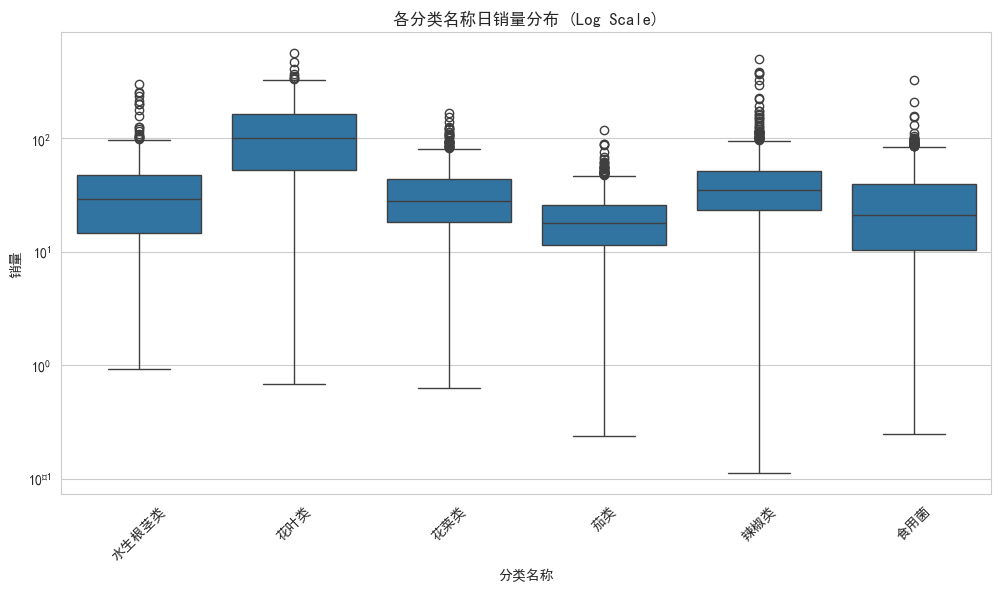

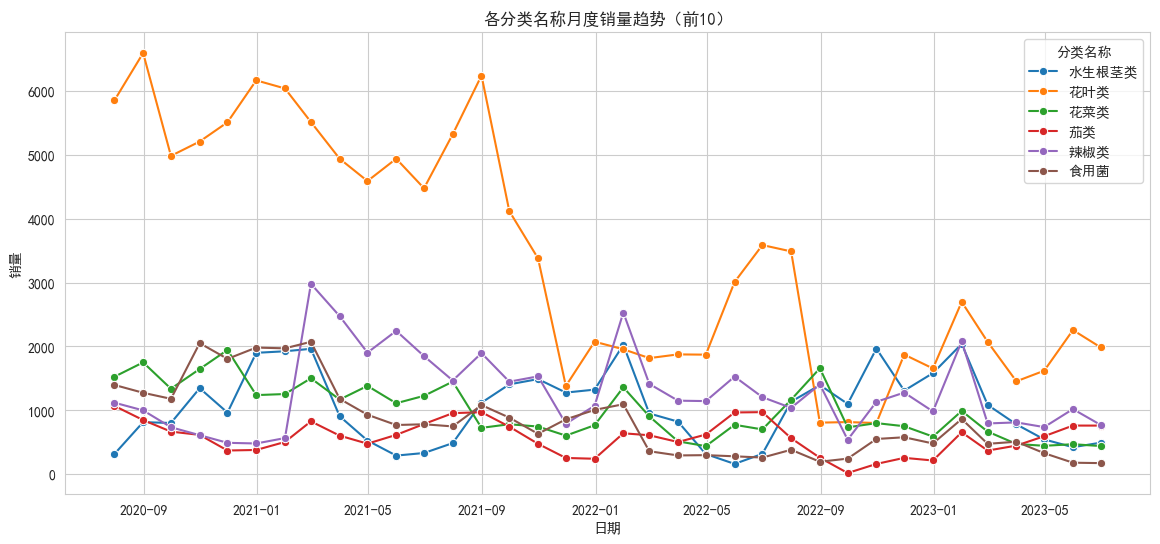

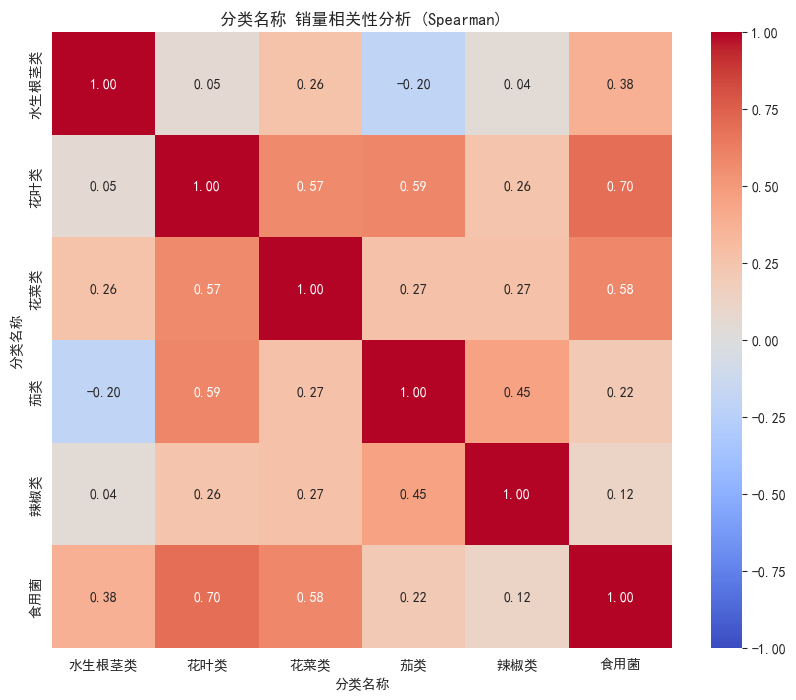

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.



--- 2. 热门单品层面分析 (Top 10) ---


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


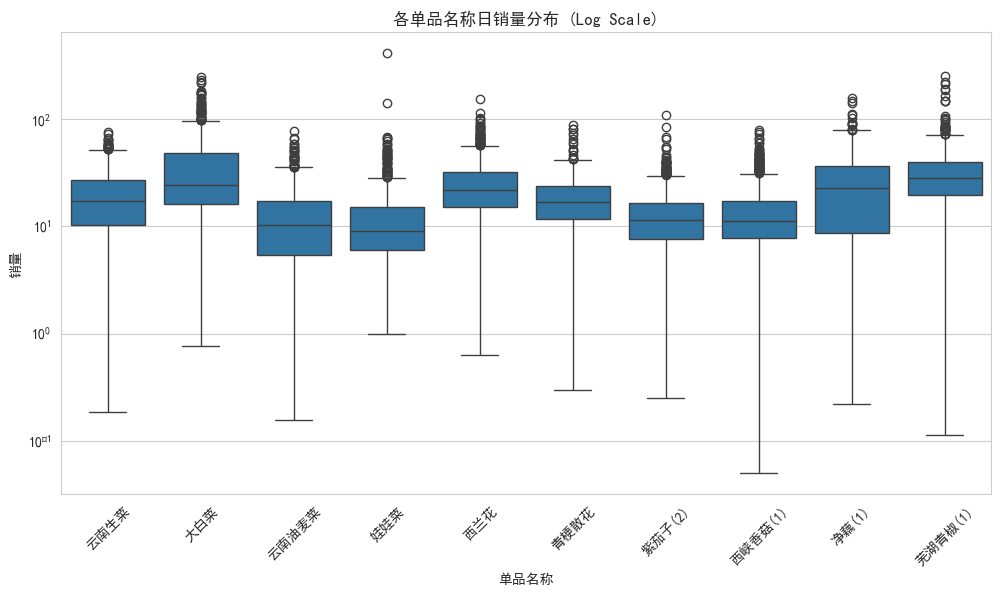

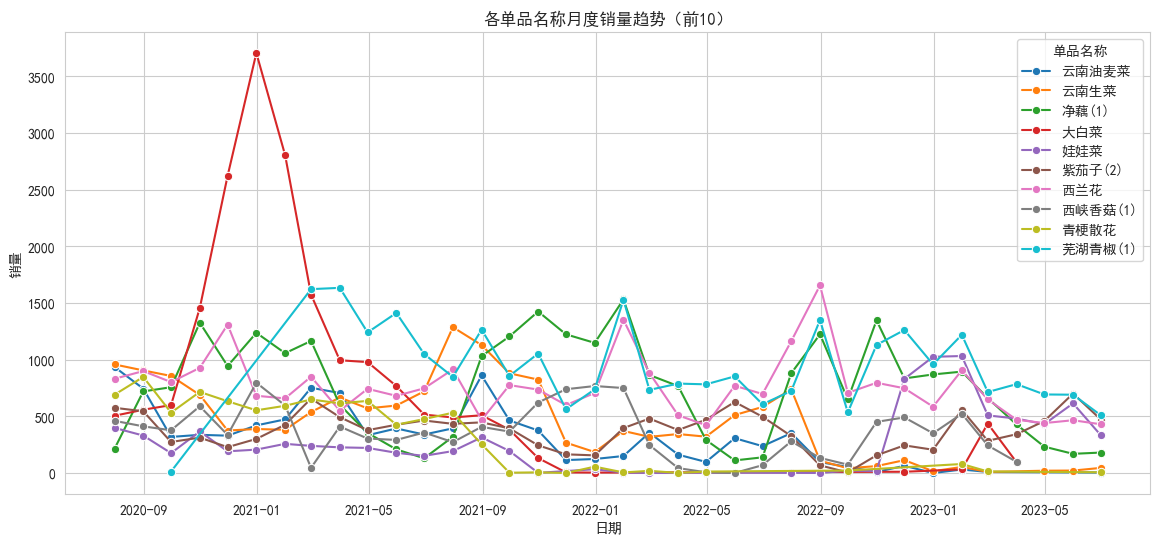

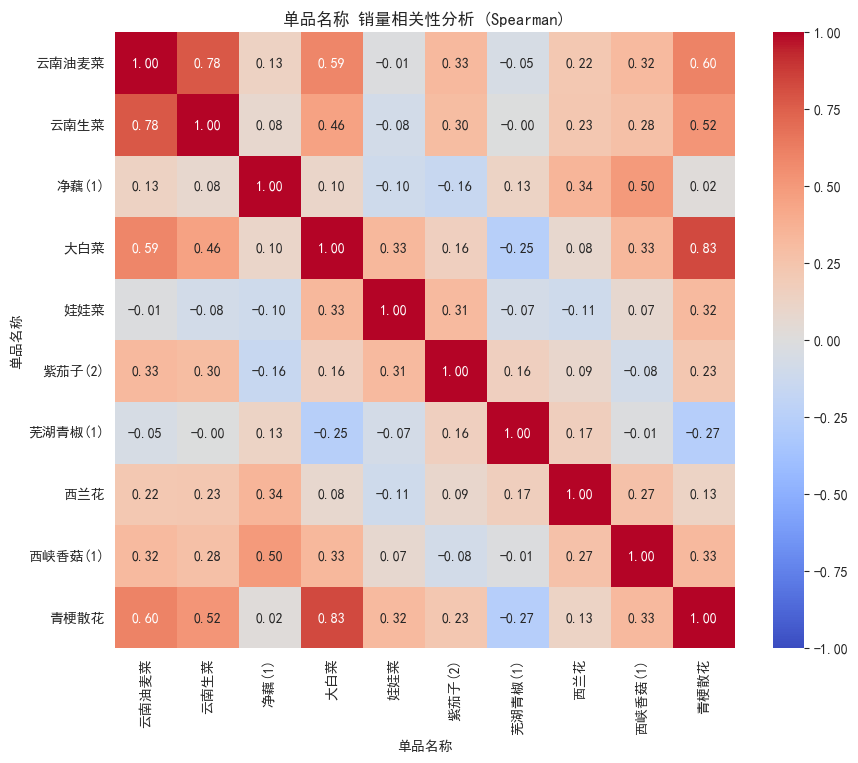

In [55]:
print("--- 1. 品类层面分析 ---")
analyze_distribution(df_cat_daily, level_name='分类名称')
corr_cat = analyze_correlation(df_cat_daily, level_name='分类名称')

print("\n--- 2. 热门单品层面分析 (Top 10) ---")
# 单品太多，只分析销量前10名
top_skus = df_sku_daily.groupby('单品名称')['销量'].sum().nlargest(10).index
df_top_sku = df_sku_daily[df_sku_daily['单品名称'].isin(top_skus)]

analyze_distribution(df_top_sku, level_name='单品名称')
corr_sku = analyze_correlation(df_top_sku, level_name='单品名称')

In [56]:
def generate_text_report(df_sku_daily, df_cat_daily):
    print(" === 蔬菜销售数据统计报告 ===\n")
    
    # --- 1. 单品销售 TOP 10 ---
    print(" [单品销量 TOP 10]")
    # 按单品名称汇总总销量
    top_10 = df_sku_daily.groupby('单品名称')['销量'].sum().nlargest(10)
    for i, (name, sales) in enumerate(top_10.items(), 1):
        total_sales = df_sku_daily['销量'].sum()
        share = (sales / total_sales) * 100
        print(f"   NO.{i}: {name:<10} 销量: {sales:,.0f} kg (占比 {share:.2f}%)")
    print("-" * 40)

    # --- 2. 品类年度分析 ---
    print("\n [各品类年度销量概览]")
    #透视表：行=品类，列=年份，值=销量
    yearly_pivot = df_cat_daily.pivot_table(index='分类名称', columns='年份', values='销量', aggfunc='sum')
    # 填充NaN并格式化输出
    print(yearly_pivot.fillna(0).round(1))
    print("-" * 40)

    # --- 3. 季节性分析 ---
    print("\n [各品类季节热度分析 (日均销量)]")
    quarterly_pivot = df_cat_daily.pivot_table(index='分类名称', columns='季节', values='销量', aggfunc='mean')
    print(quarterly_pivot.round(1))
    print("   (注: 采用气象季节划分，春=3-5月, 夏=6-8月, 秋=9-11月, 冬=12-2月)")
    print("-" * 40)

    # --- 4. 周末效应分析 ---
    print("\n [周末 vs 工作日 销量对比]")
    weekend_analysis = df_cat_daily.groupby(['分类名称', '是否周末'])['销量'].mean().unstack()
    weekend_analysis.columns = ['工作日均值', '周末均值']
    weekend_analysis['周末提升率'] = (weekend_analysis['周末均值'] - weekend_analysis['工作日均值']) / weekend_analysis['工作日均值']
    
    print(f"{'分类名称':<10} {'工作日均值':<10} {'周末均值':<10} {'提升率'}")
    for cat in weekend_analysis.index:
        row = weekend_analysis.loc[cat]
        print(f"{cat:<10} {row['工作日均值']:<10.1f} {row['周末均值']:<10.1f} {row['周末提升率']:+.2%}")

In [57]:
generate_text_report(df_sku_daily, df_cat_daily)

 === 蔬菜销售数据统计报告 ===

 [单品销量 TOP 10]
   NO.1: 芜湖青椒(1)    销量: 28,182 kg (占比 9.61%)
   NO.2: 西兰花        销量: 27,556 kg (占比 9.39%)
   NO.3: 净藕(1)      销量: 27,166 kg (占比 9.26%)
   NO.4: 大白菜        销量: 19,196 kg (占比 6.54%)
   NO.5: 云南生菜       销量: 15,915 kg (占比 5.43%)
   NO.6: 紫茄子(2)     销量: 13,609 kg (占比 4.64%)
   NO.7: 西峡香菇(1)    销量: 11,929 kg (占比 4.07%)
   NO.8: 云南油麦菜      销量: 10,309 kg (占比 3.51%)
   NO.9: 娃娃菜        销量: 9,002 kg (占比 3.07%)
   NO.10: 青梗散花       销量: 8,394 kg (占比 2.86%)
----------------------------------------

 [各品类年度销量概览]
年份        2020     2021     2022     2023
分类名称                                     
水生根茎类   6128.0  13019.0  13053.4   5350.2
花叶类    34329.3  53030.1  23539.7  12076.9
花菜类     9433.0  12689.9  10359.9   3467.5
茄类      3932.2   7421.6   5746.4   3572.9
辣椒类     4420.4  20200.0  15325.1   6198.9
食用菌     9680.7  12889.9   4980.5   2511.4
----------------------------------------

 [各品类季节热度分析 (日均销量)]
季节       春季     夏季     秋季     冬季
分类名称                         

In [58]:
seasonly = df_cat_daily.groupby(['季节', '分类名称']).agg({
    '销量': 'mean'  # 季节日均销量
}).reset_index()

season_desc = {
    '春季': '春季(3-5月)',
    '夏季': '夏季(6-8月)',
    '秋季': '秋季(9-11月)',
    '冬季': '冬季(12-2月)'
}

print("\n [季节性波动分析（旺季/淡季）]")
for cat in seasonly['分类名称'].unique():
    cat_data = seasonly[seasonly['分类名称'] == cat]
    if cat_data.empty: continue
    
    # 找到最大值和最小值所在的行
    peak = cat_data.loc[cat_data['销量'].idxmax()]
    low = cat_data.loc[cat_data['销量'].idxmin()]
    
    # 计算差异百分比
    if low['销量'] > 0:
        diff = (peak['销量'] - low['销量']) / low['销量'] * 100
    else:
        diff = float('inf') # 避免除以零

    peak_str = season_desc.get(peak['季节'], peak['季节'])
    low_str = season_desc.get(low['季节'], low['季节'])
    
    print(f"   {cat:<6}: 旺季 [{peak_str}], 淡季 [{low_str}], 波动幅度 {diff:+.0f}%")


 [季节性波动分析（旺季/淡季）]
   水生根茎类 : 旺季 [冬季(12-2月)], 淡季 [春季(3-5月)], 波动幅度 +227%
   花叶类   : 旺季 [夏季(6-8月)], 淡季 [春季(3-5月)], 波动幅度 +44%
   花菜类   : 旺季 [夏季(6-8月)], 淡季 [春季(3-5月)], 波动幅度 +54%
   茄类    : 旺季 [夏季(6-8月)], 淡季 [秋季(9-11月)], 波动幅度 +69%
   辣椒类   : 旺季 [冬季(12-2月)], 淡季 [秋季(9-11月)], 波动幅度 +55%
   食用菌   : 旺季 [冬季(12-2月)], 淡季 [春季(3-5月)], 波动幅度 +129%


In [59]:
def analyze_price_elasticity_report(df_daily, level_name='分类名称'):
    """
    计算各品类/单品的价格与销量的 Spearman 相关性
    """
    print(f"📊 === {level_name} 价格-销量 Spearman 相关性分析 ===\n")
    
    results = []
    categories = df_daily[level_name].unique()
    
    for cat in categories:
        sub_df = df_daily[df_daily[level_name] == cat].copy()
        if len(sub_df) < 10:  # 样本太少不计算
            continue
            
        r, p_value = stats.spearmanr(sub_df['加权单价'], sub_df['销量'])

        significance = "显著" if p_value < 0.05 else "不显著"
        abs_r = abs(r)
        if abs_r > 0.7:
            strength = "强"
        elif abs_r > 0.4:
            strength = "中等"
        else:
            strength = "弱"
            
        # 判断方向
        direction = "负相关" if r < 0 else "正相关"
        
        results.append({
            level_name: cat,
            'Spearman系数': r,
            'p值': p_value,
            '显著性': significance,
            '强度': strength,
            '方向': direction
        })
    
    # 转为 DataFrame 并按相关系数排序 (负相关越强越靠前)
    res_df = pd.DataFrame(results).sort_values('Spearman系数')

    # 设置 pandas 显示参数以便在 Notebook 中看清
    print(f"{'分类名称':<12} {'Spearman系数':<15} {'p值':<10} {'显著性':<8} {'强度':<8} {'方向'}")
    print("-" * 70)
    for index, row in res_df.iterrows():
        print(f"{row[level_name]:<12} {row['Spearman系数']:<15.3f} {row['p值']:<10.3f} {row['显著性']:<8} {row['强度']:<8} {row['方向']}")
    
    print("-" * 70)
    
    significant_items = res_df[res_df['p值'] < 0.05]
    if not significant_items.empty:
        print("显著相关的品类 (p < 0.05):")
        for strength_level in ['强', '中等', '弱']:
            items = significant_items[significant_items['强度'] == strength_level]
            if not items.empty:
                print(f"  {strength_level}{items.iloc[0]['方向']}:") # 例如：中等负相关
                for _, row in items.iterrows():
                    print(f"    - {row[level_name]}: r={row['Spearman系数']:.3f}, p={row['p值']:.3f}")
    else:
        print("  未发现显著的相关关系。")

    return res_df

In [60]:
elasticity_df = analyze_price_elasticity_report(df_cat_daily, level_name='分类名称')

📊 === 分类名称 价格-销量 Spearman 相关性分析 ===

分类名称         Spearman系数      p值         显著性      强度       方向
----------------------------------------------------------------------
食用菌          -0.589          0.000      显著       中等       负相关
水生根茎类        -0.506          0.000      显著       中等       负相关
辣椒类          -0.428          0.000      显著       中等       负相关
花菜类          -0.395          0.000      显著       弱        负相关
茄类           -0.277          0.000      显著       弱        负相关
花叶类          -0.129          0.000      显著       弱        负相关
----------------------------------------------------------------------
显著相关的品类 (p < 0.05):
  中等负相关:
    - 食用菌: r=-0.589, p=0.000
    - 水生根茎类: r=-0.506, p=0.000
    - 辣椒类: r=-0.428, p=0.000
  弱负相关:
    - 花菜类: r=-0.395, p=0.000
    - 茄类: r=-0.277, p=0.000
    - 花叶类: r=-0.129, p=0.000


负相关系数绝对值越大，说明该商品对价格越敏感

In [61]:
def analyze_sensitive_interactions(df_daily, level_name='分类名称', sensitivity_threshold=-0.3):
    """
    1. 计算价格弹性，找出“价格敏感”群体。
    2. 绘制该群体内部的“销量相关性”热力图。
    """
    print(f" === {level_name} 敏感分析  ===\n")
    
    # --- 计算价格敏感性 ---
    elasticity_list = []
    items = df_daily[level_name].unique()
    
    for item in items:
        sub_df = df_daily[df_daily[level_name] == item].dropna()
        if len(sub_df) < 30: continue # 样本太少不分析
        
        # Spearman 价格-销量 相关性
        r, p = stats.spearmanr(sub_df['加权单价'], sub_df['销量'])
        
        elasticity_list.append({
            level_name: item,
            'Price_Corr': r,
            'P_Value': p,
            'Type': '敏感' if (r < sensitivity_threshold and p < 0.05) else '不敏感'
        })
    
    df_ela = pd.DataFrame(elasticity_list)
    
    # 筛选出敏感品类/单品
    sensitive_items = df_ela[df_ela['Type'] == '敏感'].sort_values('Price_Corr')
    sensitive_names = sensitive_items[level_name].tolist()
    
    print(f" [分类结果]")
    print(f"   总分析数量: {len(df_ela)}")
    print(f"   价格敏感组 (Corr < {sensitivity_threshold}): {len(sensitive_items)} 个")
    print(f"   非敏感/弱相关组: {len(df_ela) - len(sensitive_items)} 个")
    
    print(f"\n[价格敏感{level_name}清单 (按敏感度排序)]")
    print(f"{level_name:<15} {'价格-销量相关系数':<15} {'P值':<10}")
    print("-" * 50)
    for _, row in sensitive_items.iterrows():
        print(f"{row[level_name]:<15} {row['Price_Corr']:<15.3f} {row['P_Value']:<10.3f}")
        
    if len(sensitive_names) < 2:
        print("\n敏感项目少于2个，无法绘制交互热力图。")
        return df_ela

    # --- 绘制敏感群体内部的“销量交互”热力图 ---
    print(f"\n[正在绘制 '{len(sensitive_names)} 个敏感{level_name}' 之间的销量相关性热力图]...")
    print("   (目的: 观察这些只要一降价就疯抢的商品，它们之间是不是存在'买了A就不买B'的替代关系)")

    # 1. 提取这些敏感项的销量数据
    target_df = df_daily[df_daily[level_name].isin(sensitive_names)]
    
    # 2. 透视表：日期 x 项目 -> 销量
    pivot_sales = target_df.pivot_table(index='日期', columns=level_name, values='销量', aggfunc='sum').fillna(0)
    
    # 3. 计算它们之间的销量相关性
    sales_corr = pivot_sales.corr(method='spearman')
    
    # 4. 画图
    plt.figure(figsize=(10, 8))
    sns.heatmap(sales_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1)
    plt.title(f'价格敏感{level_name}间的【销量】相关性热力图')
    plt.show()
    
    return df_ela

 === 分类名称 敏感分析  ===

 [分类结果]
   总分析数量: 6
   价格敏感组 (Corr < -0.4): 3 个
   非敏感/弱相关组: 3 个

[价格敏感分类名称清单 (按敏感度排序)]
分类名称            价格-销量相关系数       P值        
--------------------------------------------------
食用菌             -0.589          0.000     
水生根茎类           -0.506          0.000     
辣椒类             -0.428          0.000     

[正在绘制 '3 个敏感分类名称' 之间的销量相关性热力图]...
   (目的: 观察这些只要一降价就疯抢的商品，它们之间是不是存在'买了A就不买B'的替代关系)


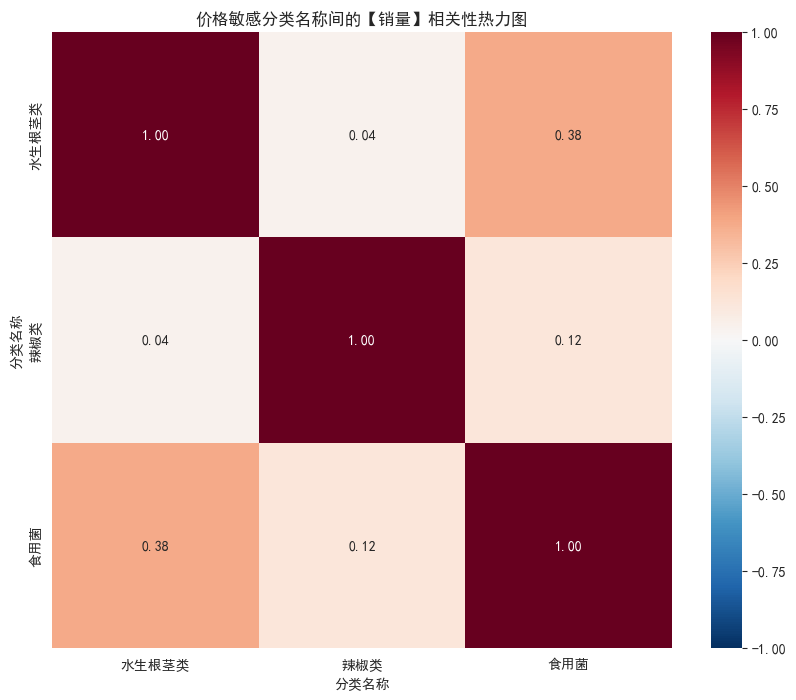

 === 单品名称 敏感分析  ===

 [分类结果]
   总分析数量: 65
   价格敏感组 (Corr < -0.4): 13 个
   非敏感/弱相关组: 52 个

[价格敏感单品名称清单 (按敏感度排序)]
单品名称            价格-销量相关系数       P值        
--------------------------------------------------
竹叶菜             -0.680          0.000     
豌豆尖             -0.594          0.000     
苋菜              -0.551          0.000     
面条菜             -0.528          0.002     
青茄子(1)          -0.518          0.000     
大白菜             -0.499          0.000     
洪湖藕带            -0.486          0.000     
长线茄             -0.473          0.000     
螺丝椒             -0.446          0.000     
红薯尖             -0.439          0.000     
白菜苔             -0.426          0.000     
枝江红菜苔           -0.424          0.000     
圆茄子(2)          -0.413          0.000     

[正在绘制 '13 个敏感单品名称' 之间的销量相关性热力图]...
   (目的: 观察这些只要一降价就疯抢的商品，它们之间是不是存在'买了A就不买B'的替代关系)


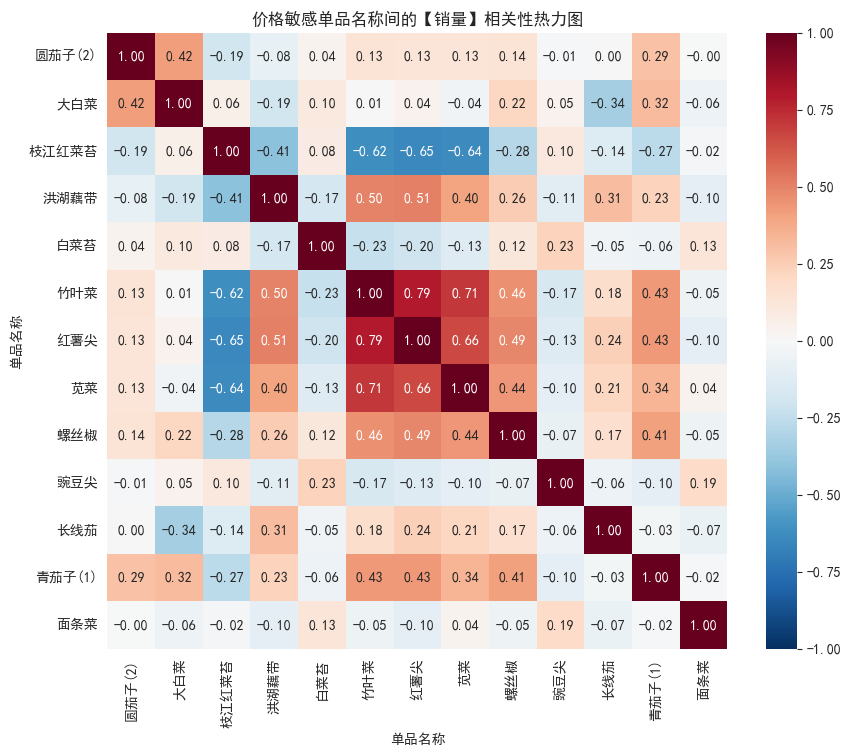

In [62]:
res_cat = analyze_sensitive_interactions(df_cat_daily, level_name='分类名称', sensitivity_threshold=-0.4)

res_sku = analyze_sensitive_interactions(df_sku_daily, level_name='单品名称', sensitivity_threshold=-0.4)

# 问题2 
考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略，使得商超收益最大。

## 成本计算

In [ ]:
def clean_wholesale_3sigma(df_wholesale, price_col='批发价格(元/千克)'):
    """
    使用 3-Sigma 原则去除批发价格中的异常值
    逻辑：对每个单品，剔除价格在 (μ - 3σ, μ + 3σ) 之外的数据
    """
    
    original_count = len(df_wholesale)
    df = df_wholesale.copy()
    
    # 1. 计算每个单品的均值(mean)和标准差(std)
    # transform 会返回与原 dataframe 长度一致的序列，方便直接比较
    df['mean_price'] = df.groupby('单品编码')[price_col].transform('mean')
    df['std_price'] = df.groupby('单品编码')[price_col].transform('std')
    
    # 2. 定义异常值判定边界：下限不能低于0 (价格非负)
    df['lower_bound'] = (df['mean_price'] - 3 * df['std_price']).apply(lambda x: max(0, x))
    df['upper_bound'] = df['mean_price'] + 3 * df['std_price']
    
    # 3. 筛选正常数据
    # 保留条件：(价格在范围内) 或 (标准差为空，说明只有1条数据，无法判断异常，保留)
    mask = (
        (df[price_col] >= df['lower_bound']) & 
        (df[price_col] <= df['upper_bound'])
    ) | df['std_price'].isna()
    
    df_clean = df[mask].copy()
    
    # 4. 统计清洗效果
    removed_count = original_count - len(df_clean)
    print(f"   - 原始记录数: {original_count}")
    print(f"   - 清洗后记录: {len(df_clean)}")
    print(f"   - 剔除异常值: {removed_count} 条 (占比 {removed_count/original_count:.2%})")
    
    # 5. 删除中间辅助列
    return df_clean.drop(columns=['mean_price', 'std_price', 'lower_bound', 'upper_bound'])

def calculate_precise_costs(df_sku_daily, raw_wholesale, raw_loss, raw_category):


    df = df_sku_daily.copy()
    raw_wholesale = raw_wholesale.copy()
    raw_loss = raw_loss.copy()
    raw_category = raw_category.copy()
    raw_wholesale['日期'] = pd.to_datetime(raw_wholesale['日期'])

    for d in [df, raw_wholesale, raw_loss, raw_category]:
        if '单品编码' in d.columns:
            d['单品编码'] = d['单品编码'].astype(str).str.strip()
    
    raw_loss.columns = ['单品编码', '单品名称', '损耗率(%)']

    print("   -> 关联单品批发价格...")
    df = pd.merge(df, raw_wholesale[['日期', '单品编码', '批发价格(元/千克)']], 
                  on=['日期', '单品编码'], how='left')
    df.rename(columns={'批发价格(元/千克)': '批发单价'}, inplace=True)
    
    print("   -> 关联单品损耗率...")
    loss_map = raw_loss[['单品编码', '损耗率(%)']].drop_duplicates()
    df = pd.merge(df, loss_map, on='单品编码', how='left')
    
    # 数据清洗：损耗率转小数，缺失填 0
    df['损耗率'] = df['损耗率(%)'].fillna(0) / 100
    
    # 如果某单品某天没进货，假设成本与最近一次进货持平
    print("   -> 填充缺失成本数据 (ffill/bfill)...")
    df['批发单价'] = df.groupby('单品编码')['批发单价'].ffill()
    df['批发单价'] = df.groupby('单品编码')['批发单价'].bfill()
    
    # 如果仍有缺失 (从未进货的单品)，用该品类的平均批发价填充 (兜底策略)
    # 品类日均价
    if '分类名称' not in df.columns:
        df = pd.merge(df, raw_category[['单品编码', '分类名称']], on='单品编码', how='left')
    cat_avg_cost = df.groupby(['日期', '分类名称'])['批发单价'].transform('mean')
    df['批发单价'] = df['批发单价'].fillna(cat_avg_cost)

    # 单品成本与加成率
    df['单品真实成本'] = df['批发单价'] / (1 - df['损耗率'])
    df['单品成本加成率'] = (df['加权单价'] - df['单品真实成本']) / df['单品真实成本']
    df['单品总成本'] = df['单品真实成本'] * df['销量']

    print("    单品级计算完成。")

    print("   -> 执行品类加权聚合...")
    
    # 按 [日期, 分类名称] 聚合
    # 销量、销售额、单品总成本 -> 求和
    df_cat_final = df.groupby(['日期', '分类名称']).agg({
        '销量': 'sum',
        '销售额': 'sum',      # 实际销售收入
        '单品总成本': 'sum',  # 实际总成本 (含损耗)
    }).reset_index()
    
    # 品类加权单价、真实成本（加权平均成本）、成本加成率
    df_cat_final['加权单价'] = df_cat_final['销售额'] / df_cat_final['销量']
    df_cat_final['真实成本'] = df_cat_final['单品总成本'] / df_cat_final['销量']
    df_cat_final['成本加成率'] = (df_cat_final['加权单价'] - df_cat_final['真实成本']) / df_cat_final['真实成本']

    df_cat_final['年份'] = df_cat_final['日期'].dt.year
    df_cat_final['月份'] = df_cat_final['日期'].dt.month
    df_cat_final['是否周末'] = df_cat_final['日期'].dt.weekday.isin([5, 6])
    df_cat_final['季节'] = df_cat_final['月份'].apply(get_season)

    print(f"    品类级计算完成! 形状: {df_cat_final.shape}")
    
    # 返回：
    # 1. df_cat_final: 品类日度数据 (用于训练需求模型)
    # 2. df: 单品日度数据 (用于单品分析)
    # 3. avg_loss_per_cat: 品类静态损耗率 (用于后续优化模型)
    return df_cat_final, df

In [ ]:
raw_wholesale_clean = clean_wholesale_3sigma(raw_wholesale)

df_cat_final, df_sku_detailed = calculate_precise_costs(
    df_sku_daily, 
    raw_wholesale_clean, 
    raw_loss, 
    raw_category
)
print("\n[品类数据示例]")
print(df_cat_final[['日期', '分类名称', '加权单价', '真实成本', '成本加成率']].tail())

   - 原始记录数: 55982
   - 清洗后记录: 55463
   - 剔除异常值: 519 条 (占比 0.93%)
   -> 关联单品批发价格...
   -> 关联单品损耗率...
   -> 填充缺失成本数据 (ffill/bfill)...
    单品级计算完成。
   -> 执行品类加权聚合...
    品类级计算完成! 形状: (6447, 12)

[品类数据示例]
             日期 分类名称       加权单价       真实成本     成本加成率
6442 2023-06-30  花叶类   4.886392   2.888070  0.691923
6443 2023-06-30  花菜类  11.200000   7.590000  0.475626
6444 2023-06-30   茄类   8.104900   4.696215  0.725837
6445 2023-06-30  辣椒类   7.563786   5.486267  0.378676
6446 2023-06-30  食用菌  21.371896  13.974274  0.529374


In [ ]:
df_loss_category = pd.read_excel('./选题2-蔬菜自动定价与补货决策/附件4.xlsx', sheet_name='平均损耗率(%)_小分类编码_不同值') 
loss_rate_map = df_loss_category.set_index('小分类名称')['平均损耗率(%)_小分类编码_不同值'].to_dict()
loss_rate_map = {k: v / 100 for k, v in loss_rate_map.items()}
print("各品类平均损耗率:\n", loss_rate_map)

# 2. 预测未来一周的批发成本 (使用最近14天的移动平均作为简单预测)
# 注意：比赛中如果追求更高分，可以用 ARIMA 对成本进行时序预测
raw_wholesale_clean['日期'] = pd.to_datetime(raw_wholesale_clean['日期'])
df_wholesale_merged = pd.merge(raw_wholesale_clean, raw_category[['单品编码', '分类名称']], on='单品编码', how='left')
df_daily_cost = df_wholesale_merged.groupby(['日期', '分类名称'])['批发价格(元/千克)'].mean().reset_index()

future_cost_map = {}
categories = df_daily_cost['分类名称'].unique()

for cat in categories:
    cat_data = df_daily_cost[df_daily_cost['分类名称'] == cat].sort_values('日期')
    # 取最后14天的平均批发价作为未来一周的预计成本
    avg_cost = cat_data['批发价格(元/千克)'].tail(14).mean()
    future_cost_map[cat] = avg_cost

print("\n未来一周预测成本 (基于14天均值):\n", pd.Series(future_cost_map))

各品类平均损耗率:
 {'花菜类': 0.1551, '水生根茎类': 0.1365, '花叶类': 0.1283, '食用菌': 0.09449999999999999, '辣椒类': 0.0924, '茄类': 0.0668}

未来一周预测成本 (基于14天均值):
 水生根茎类    11.257160
花叶类       3.720891
花菜类       8.616429
茄类        4.846429
辣椒类       6.178932
食用菌       4.760440
dtype: float64


## 模型预测

# 问题3 
因蔬菜类商品的销售空间有限，商超希望进一步制定单品的补货计划，要求可售单品总数控制在 27-33 个，且各单品订购量满足最小陈列量 2.5 千克的要求。根据 2023 年 6 月 24-30 日的可售品种，给出 7 月 1 日的单品补货量和定价策略，在尽量满足市场对各品类蔬菜商品需求的前提助，请给出你们的意见和理由。